In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

%matplotlib inline

In [2]:
data_path = 'D://Dataset/support-ticket-classification/'

In [3]:
ddata = pd.read_csv(data_path + 'all_tickets.csv')

In [4]:
ddata.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [5]:
ddata.isnull().sum()

title               712
body                  0
ticket_type           0
category              0
sub_category1         0
sub_category2         0
business_service      0
urgency               0
impact                0
dtype: int64

In [6]:
ddata.shape

(48549, 9)

In [7]:
ddata.columns

Index(['title', 'body', 'ticket_type', 'category', 'sub_category1',
       'sub_category2', 'business_service', 'urgency', 'impact'],
      dtype='object')

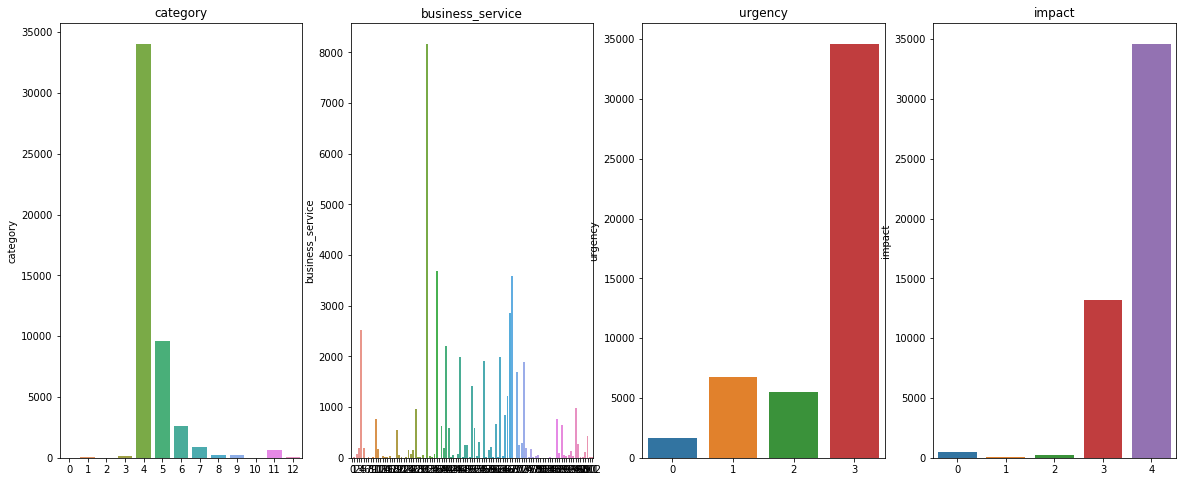

In [8]:
f, ax = plt.subplots(1, 4, figsize = (20, 8))
for i, col in enumerate(["category", 'business_service', 'urgency', 'impact']):
    sns.barplot(x = ddata[col].value_counts().index, y = ddata[col].value_counts(), ax = ax[i]).set_title(col)

In [9]:
ddata.category.value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64

In [10]:
# we remove some category that not sufficient to make a model
drop_index = ddata[ddata['category'].isin([0,2,10])].index

In [11]:
ddata.drop(drop_index, axis = 0, inplace=True)

In [12]:
map_label = dict((k, i) for i, k in enumerate(ddata.category.unique()))

In [13]:
map_label

{4: 0, 6: 1, 5: 2, 7: 3, 11: 4, 1: 5, 8: 6, 12: 7, 3: 8, 9: 9}

In [14]:
ddata['category_remap'] = ddata.category.map(map_label)

In [15]:
ddata.shape

(48540, 10)

## Cleansing

In [16]:
stopword = stopwords.words('english')

In [17]:
stem = PorterStemmer()

In [18]:
lemma = WordNetLemmatizer()

In [19]:
def cleansing(sentence):
    word_list = word_tokenize(sentence)
    word_list = [word for word in word_list if word not in stopword]
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [stem.stem(word) for word in word_list]
    word_list = [lemma.lemmatize(word) for word in word_list]
    
    text = " ".join(word_list)
    
    return text

In [20]:
ddata['body_cleansing'] = ddata.body.apply(cleansing)

In [21]:
ddata.drop(ddata[ddata.body_cleansing.str.len() < 90].index, inplace=True)

ddata.shape

(30380, 11)

In [22]:
ddata.category_remap.value_counts().sort_index()

0    21097
1     1886
2     6118
3      409
4      387
5       39
6      215
7       40
8       44
9      145
Name: category_remap, dtype: int64

In [23]:
ddata.reset_index(drop=True, inplace=True)

## Feature Extraction

In [24]:
def fe(content):
    tfidf = TfidfVectorizer()
    X = tfidf.fit_transform(content)
    
    return X

In [25]:
X = fe(ddata.body_cleansing)

In [26]:
def word_cloud(label):
    body_cleansing_list = list(ddata[ddata['category_remap'] == label].body_cleansing)
    text = " ".join(body_cleansing_list)
    text_tokenize = word_tokenize(text)
    word_freq = dict(Counter(text_tokenize))
    
    return word_freq

In [27]:
for label in sorted(ddata.category_remap.unique()):
    word_freq, label = word_cloud(label), label

In [28]:
word_freq['octob']

29

In [29]:
d_w_f = pd.DataFrame(data = {'word': list(word_freq.keys()), 'freq': list(word_freq.values())})

In [30]:
d_w_f.sort_values(by = 'freq', ascending = False)

,word,freq
7,plea,272
10,thank,187
293,sent,174
82,regard,152
163,need,137
174,purchas,117
12,hello,97
102,kind,85
205,request,72
286,licens,72


In [31]:
ddata[ddata['category_remap'] == label]

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact,category_remap,body_cleansing
16074,client sign off complete additional floor expa...,october client sign off complete additional fl...,1,9,8,0,75,3,4,9,octob client sign complet addit floor expans p...
16944,quote new,quote hi please log bellow thank administrator...,1,9,8,0,76,3,4,9,quot plea log bellow thank administr friday qu...
17201,request for quote bucharest th floor expansions,quote floor expansions hi please log bellow th...,1,9,8,0,76,3,4,9,quot floor expans plea log bellow thank admini...
17248,new project with purchasing,friday hi please log bellow quote updates than...,1,9,36,0,76,3,4,9,friday plea log bellow quot updat thank admini...
18410,quotes for its project,tuesday quotes hi please log bellow thank admi...,1,9,8,0,76,3,4,9,tuesday quot plea log bellow thank administr j...
18697,guidance needed for replacing laptop request,pm guidance needed replacing purchase hi guys ...,1,9,26,0,68,3,4,9,guidanc need replac purchas guy plea guid make...
18861,request for it final owner,tuesday july pm purchase final owner id has ap...,1,9,38,0,41,3,4,9,tuesday juli purchas final owner approv purcha...
19218,purchase request for it final owner id has bee...,friday july purchase final owner id has approv...,1,9,50,0,32,3,4,9,friday juli purchas final owner approv purchas...
19278,purchase request for it final owner id has bee...,wednesday july purchase final owner id has app...,1,9,38,0,32,3,4,9,wednesday juli purchas final owner approv hell...
19279,purchase request for it final owner id has bee...,wednesday july pm purchase final owner id has ...,1,9,48,0,32,3,4,9,wednesday juli purchas final owner approv dear...


## Model

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, ddata.category_remap, test_size = 0.20)

In [33]:
sk = StratifiedKFold(n_splits=5)

In [36]:
score_stratified = []
for train, test in sk.split(X, ddata.category_remap):
    X_train, X_test, y_train, y_test = X[train], X[test], ddata.loc[train, 'category_remap'], ddata.loc[test, 'category_remap']
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    y_pred = mnb.predict(X_test)
    score_stratified.append(eval(y_test, y_pred))

C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in l

In [37]:
score_stratified

[{'f1-score': 0.1732676882783922,
  'recall': 0.16934573776851444,
  'precision': 0.21447982273249505},
 {'f1-score': 0.23376708325429352,
  'recall': 0.2124107095518662,
  'precision': 0.42089220418312123},
 {'f1-score': 0.22757955068974275,
  'recall': 0.20397426736074667,
  'precision': 0.41765810869979925},
 {'f1-score': 0.23406642793159443,
  'recall': 0.2063079711921793,
  'precision': 0.4467327793456439},
 {'f1-score': 0.19671659861011784,
  'recall': 0.17179366822283498,
  'precision': 0.4362049766350909}]

In [38]:
pd.DataFrame(data = score_stratified)

,f1-score,precision,recall
0,0.173268,0.214480,0.169346
1,0.233767,0.420892,0.212411
2,0.227580,0.417658,0.203974
3,0.234066,0.446733,0.206308
4,0.196717,0.436205,0.171794


## Support Vector Machine

In [39]:
clf_svc = SVC()

In [40]:
clf_svc.fit(X_train, y_train)

C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [41]:
y_pred_svc = clf_svc.predict(X_test)

In [42]:
eval(y_test, y_pred_svc)

C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'f1-score': 0.08199397531823924,
 'recall': 0.1,
 'precision': 0.0694828722002635}

## Random Forest

In [43]:
rfc = RandomForestClassifier()

In [44]:
rfc.fit(X_train, y_train)

C:\Users\Andreas Chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
y_pred = rfc.predict(X_test)

## Evaluation

In [35]:
def eval(y_true, y_pred):
    f1score = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average = 'macro')
    
    return {'f1-score': f1score,
            'recall': recall,
            'precision': precision
            }